# BELLE-Style Hierarchical Sampling

Implementing BELLE paper's hierarchical sampling mechanism on our dataset.

Key features:
- 3-step hierarchical sampling (variance -> mean -> output)
- NIG parameter prediction (gamma, nu, alpha, beta)
- Sampling integrated in forward pass

## 1. Setup

In [12]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import normal_inverse_gamma, invgamma
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import zarr
import os

np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')

PyTorch: 2.9.1+cu128
Device: cuda


## 2. Data Generation (Exact same as before)

In [2]:
N = 4
n_samples = 2
dataset_size = 10000

os.makedirs('data', exist_ok=True)
dataset_zarr = zarr.open_array(
    'data/x_train.zarr', mode='w',
    shape=(dataset_size, n_samples + 1, N),
    chunks=(10, n_samples + 1, N),
    dtype='float32'
)
print(f"Zarr: {dataset_zarr.shape}")

Zarr: (10000, 3, 4)


In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def my_sample_from_gamma(x):
    inv_gamma = normal_inverse_gamma(*x)
    x_ = inv_gamma.rvs()[0]
    return x_

sample_from_gamma = np.vectorize(my_sample_from_gamma, signature="(n)->()")

def gen_X_train(N, dataset_size, rng, rng2, rng3, rng4, dataset_zarr):
    nu_seed = rng.random((N, 1))
    alpha_seed = 13 * rng.beta(rng2.random(), rng2.random(), size=(N, 1))
    mu_loc = [
        np.random.choice(np.array([-1, -0.5, 0.6, 0.3, 1]))
        * np.random.beta(np.random.random(), np.random.random())
        for _ in range(N)
    ]
    mu_scale = [np.random.beta(np.random.random(), np.random.random()) for _ in range(N)]
    
    mu_seed = rng.normal(loc=mu_loc, scale=mu_scale, size=(N, N))
    mu_seed = np.diagonal(mu_seed)[None].T
    lambda_seed = rng2.random((N, 1))
    beta_seed = rng3.random((N, 1))
    
    params = np.hstack([mu_seed, lambda_seed, alpha_seed, beta_seed])
    for _ in trange(dataset_size, desc='Gen X'):
        params_ = params.copy()
        x = sample_from_gamma(params_)
        dataset_zarr[_, 0] = x
    return dataset_zarr

rng = default_rng(34)
rng2 = default_rng(np.random.randint(1, 3090))
rng3 = default_rng(np.random.randint(1, 3090))
rng4 = default_rng(np.random.randint(1, 3090))

dataset_zarr = gen_X_train(N, dataset_size, rng, rng2, rng3, rng4, dataset_zarr)

Gen X: 100%|██████████| 10000/10000 [00:45<00:00, 218.32it/s]


## 3. Kernel Functions (Same as before)

In [4]:
def mixture_kernel_sampler(x):
    mu_1, mu_2 = 2 * x**2 + 1, -2 * x**2 - 1
    sigma = 0.3 * np.abs(np.sin(4 * x)) + 0.05
    prob_mode_1 = 1 / (1 + np.exp(-5 * x))
    mode_choice = np.random.rand() < prob_mode_1
    return np.random.normal(loc=mu_1 if mode_choice else mu_2, scale=sigma)

def hierarchical_nig_sampler(x):
    '''BELLE hierarchical sampling from paper'''
    gamma = 3 * x
    nu = np.abs(x) + 1.0
    alpha = min(2.0 + np.exp(-0.5 * x**3), 100.0)
    beta = 0.5
    sigma_sq = invgamma.rvs(a=alpha, scale=beta)
    mean_variance = sigma_sq / nu
    sampled_mu = np.random.normal(loc=gamma, scale=np.sqrt(mean_variance)) * x
    return np.random.normal(loc=sampled_mu, scale=np.sqrt(sigma_sq))

def jump_diffusion_sampler(x):
    drift = np.sin(3 * x)
    diffusion_noise = np.random.normal(0, 0.2)
    jump_prob = 0.05 + 0.4 * (np.abs(x) > 1.5)
    is_jump = np.random.rand() < jump_prob
    jump_val = (np.random.choice([-2, 2]) + np.random.normal(0, 0.5)) if is_jump else 0
    return drift + diffusion_noise + jump_val

def fractal_weierstrass_sampler(x, K=10):
    b = 2.0 + 0.5 * np.sin(x)
    a = 0.5 / (1 + np.abs(x))
    y_sum = sum((a**k) * np.cos((b**k) * np.pi * x + np.random.uniform(0, 2*np.pi)) for k in range(K))
    return y_sum + np.random.normal(0, 0.05)

def stochastic_volatility_jump_sampler(x):
    mu, base_vol, jump_prob = (0.5*x, 0.1, 0.4) if x > 0 else (0.5*x, 0.4, 0.2)
    realized_vol = base_vol * np.exp(np.random.normal(0, 0.2))
    is_jump = np.random.rand() < jump_prob
    jump_size = np.random.normal(-2.0, 0.5) if is_jump else 0
    return mu + np.random.normal(0, realized_vol) + jump_size

print("Kernels defined!")

Kernels defined!


## 4. Target Generation

In [5]:
kernel_funcs = [mixture_kernel_sampler, hierarchical_nig_sampler, jump_diffusion_sampler, 
                 stochastic_volatility_jump_sampler, fractal_weierstrass_sampler]
kernel_pos = np.random.choice(kernel_funcs, size=(N,), replace=False)

def gen_targets(x, n_samples):
    y_targets = []
    for _ in range(n_samples):
        target = [kernel_pos[i](x[i]) for i in range(4)]
        y_targets.append(target)
    return y_targets

for i in trange(dataset_size, desc='Gen targets'):
    _x = dataset_zarr[i, 0]
    targets = gen_targets(_x, n_samples)
    for j in range(n_samples):
        dataset_zarr[i, j+1] = targets[j]

print(f"Dataset: {dataset_zarr.shape}")

Gen targets: 100%|██████████| 10000/10000 [00:25<00:00, 397.76it/s]

Dataset: (10000, 3, 4)


## 5. Train/Val/Test Split

In [13]:
indices = np.arange(dataset_size)
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

class BELLEDataset(Dataset):
    def __init__(self, data_source, indices):
        self.data = data_source
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        sample = self.data[actual_idx]
        x, y1, y2 = sample[0:1, :], sample[1:2, :], sample[2:3, :]
        x = np.nan_to_num(x, nan=0.0, posinf=10.0, neginf=-10.0)
        y1 = np.nan_to_num(y1, nan=0.0, posinf=50.0, neginf=-50.0)
        y2 = np.nan_to_num(y2, nan=0.0, posinf=50.0, neginf=-50.0)
        return x, y1, y2

train_dataset = BELLEDataset(dataset_zarr, train_indices)
val_dataset = BELLEDataset(dataset_zarr, val_indices)
test_dataset = BELLEDataset(dataset_zarr, test_indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

Train: 8000, Val: 1000, Test: 1000


## 6. BELLE-Style Model

Implements the hierarchical sampling mechanism from BELLE paper:
1. Predict NIG parameters (gamma, nu, alpha, beta)
2. Sample variance from Inverse Gamma
3. Sample mean from Normal
4. Sample output from Normal

In [14]:
class BELLESamplingModule(nn.Module):
    '''
    BELLE-style hierarchical sampling model.
    Based on the paper's 3-step sampling mechanism.
    
    Parameters predicted:
    - gamma (γ): Expected mean
    - nu (ν): Evidence count (confidence in mean)
    - alpha (α): Shape of variance distribution
    - beta (β): Scale of variance distribution
    '''
    
    def __init__(self, input_dim=4, hidden_dim=256):
        super().__init__()
        
        # Encoder (similar to BELLE paper)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        # Projection heads for NIG parameters
        self.gamma_head = nn.Linear(hidden_dim, input_dim)    # Expected mean
        self.nu_head = nn.Linear(hidden_dim, input_dim)       # Evidence count
        self.alpha_head = nn.Linear(hidden_dim, input_dim)    # Variance shape
        self.beta_head = nn.Linear(hidden_dim, input_dim)     # Variance scale
        
        self._init_weights()
    
    def _init_weights(self):
        '''Conservative weight initialization'''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x, sample=True):
        '''
        Forward pass with BELLE hierarchical sampling.
        
        Returns: (gamma, nu, alpha, beta, y_sample)
        '''
        x = torch.nan_to_num(x, nan=0.0, posinf=10.0, neginf=-10.0)
        
        # Encode input
        h = self.encoder(x)
        
        # Predict NIG parameters using softplus (as in paper)
        gamma = self.gamma_head(h)  # Expected mean (unbounded)
        nu = F.softplus(self.nu_head(h)) + 1e-6  # Evidence count (positive)
        alpha = F.softplus(self.alpha_head(h)) + 1.0 + 1e-6  # Shape (> 1)
        beta = F.softplus(self.beta_head(h)) + 1e-6  # Scale (positive)
        
        if sample:
            y_sample = self._hierarchical_sample(gamma, nu, alpha, beta)
        else:
            y_sample = gamma  # Return mean if not sampling
        
        return gamma, nu, alpha, beta, y_sample
    
    def _hierarchical_sample(self, gamma, nu, alpha, beta):
        '''
        3-step hierarchical sampling (BELLE paper mechanism):
        Step 1: Sample variance σ² ~ InvGamma(α, β)
        Step 2: Sample mean μ ~ Normal(γ, σ²/ν)
        Step 3: Sample output y ~ Normal(μ, σ²)
        '''
        eps = 1e-6
        
        # Ensure valid parameters
        nu = torch.clamp(nu, min=eps, max=20.0)
        alpha = torch.clamp(alpha, min=2.0, max=20.0)
        beta = torch.clamp(beta, min=eps, max=10.0)
        
        try:
            # Step 1: Sample variance from Inverse Gamma
            gamma_dist = torch.distributions.Gamma(alpha, beta)
            variance = 1.0 / (gamma_dist.sample() + eps)
            variance = torch.clamp(variance, min=eps, max=100.0)
            
            # Step 2: Sample mean from Normal(gamma, variance/nu)
            mean_std = torch.sqrt(variance / nu)
            mean_dist = torch.distributions.Normal(gamma, mean_std)
            sampled_mean = mean_dist.sample()
            
            # Step 3: Sample output from Normal(sampled_mean, sqrt(variance))
            output_dist = torch.distributions.Normal(sampled_mean, torch.sqrt(variance))
            output = output_dist.sample()
            
            return torch.clamp(output, min=-50.0, max=50.0)
        except:
            return gamma  # Fallback to expected mean

print("BELLESamplingModule defined!")
print("✓ 3-step hierarchical sampling")
print("✓ NIG parameters: gamma, nu, alpha, beta")
print("✓ Sampling in forward pass")

BELLESamplingModule defined!
✓ 3-step hierarchical sampling
✓ NIG parameters: gamma, nu, alpha, beta
✓ Sampling in forward pass


## 7. Loss Function (BELLE NLL)

In [15]:
def belle_nll_loss(y_true, gamma, nu, alpha, beta):
    '''
    Negative Log-Likelihood for NIG distribution (BELLE paper).
    The marginal distribution is Student-t.
    '''
    eps = 1e-6
    nu = torch.clamp(nu, min=eps, max=20.0)
    alpha = torch.clamp(alpha, min=2.0, max=20.0)
    beta = torch.clamp(beta, min=eps, max=10.0)
    
    # Student-t NLL formula (from NIG marginal)
    two_beta_nu = 2 * beta * (1 + nu)
    
    term1 = 0.5 * torch.log(torch.tensor(np.pi, device=y_true.device) / nu)
    term2 = -alpha * torch.log(two_beta_nu)
    
    sq_error = torch.clamp((y_true - gamma) ** 2, min=eps, max=1e4)
    term3 = (alpha + 0.5) * torch.log(nu * sq_error + two_beta_nu)
    
    term4 = torch.lgamma(alpha) - torch.lgamma(alpha + 0.5)
    
    nll = term1 + term2 + term3 + term4
    nll = torch.where(torch.isnan(nll) | torch.isinf(nll),
                      torch.tensor(50.0, device=nll.device), nll)
    return nll.mean()

def belle_sampling_loss(y_true, y_sampled):
    '''MSE between true and sampled'''
    return F.mse_loss(y_sampled, y_true)

def belle_total_loss(y_true, gamma, nu, alpha, beta, y_sampled, nll_weight=1.0, mse_weight=0.5):
    '''Combined BELLE loss'''
    loss_nll = belle_nll_loss(y_true, gamma, nu, alpha, beta)
    loss_mse = belle_sampling_loss(y_true, y_sampled)
    total = nll_weight * loss_nll + mse_weight * loss_mse
    
    if torch.isnan(total) or torch.isinf(total):
        return torch.tensor(100.0, device=total.device, requires_grad=True)
    return torch.clamp(total, max=1000.0)

print("BELLE loss functions ready!")

BELLE loss functions ready!


## 8. Training (BELLE hyperparameters)

In [16]:
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for x, y1, y2 in dataloader:
        x = x.squeeze(1).float().to(device)
        y1 = y1.squeeze(1).float().to(device)
        y2 = y2.squeeze(1).float().to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with hierarchical sampling
        gamma1, nu1, alpha1, beta1, y1_sampled = model(x, sample=True)
        loss1 = belle_total_loss(y1, gamma1, nu1, alpha1, beta1, y1_sampled)
        
        # gamma2, nu2, alpha2, beta2, y2_sampled = model(x, sample=True)
        loss2 = belle_total_loss(y2, gamma1, nu1, alpha1, beta1, y1_sampled)
        
        loss = loss1 + loss2
        
        if not (torch.isnan(loss) or torch.isinf(loss)):
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / max(num_batches, 1)

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for x, y1, y2 in dataloader:
            x = x.squeeze(1).float().to(device)
            y1 = y1.squeeze(1).float().to(device)
            y2 = y2.squeeze(1).float().to(device)
            
            gamma1, nu1, alpha1, beta1, y1_sampled = model(x, sample=True)
            loss1 = belle_total_loss(y1, gamma1, nu1, alpha1, beta1, y1_sampled)
            
            # gamma2, nu2, alpha2, beta2, y2_sampled = model(x, sample=True)
            loss2 = belle_total_loss(y2, gamma1, nu1, alpha1, beta1, y1_sampled)
            
            loss = loss1 + loss2
            
            if not (torch.isnan(loss) or torch.isinf(loss)):
                total_loss += loss.item()
                num_batches += 1
    
    return total_loss / max(num_batches, 1)

print("Training functions ready!")

Training functions ready!


In [17]:
# Initialize model (BELLE-style architecture)
model = BELLESamplingModule(input_dim=4, hidden_dim=256)
model = model.to(device)

# Improved optimizer settings for stability
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0001,
    weight_decay=1e-5,
    betas=(0.9, 0.98),  # Higher beta2 for more stable updates
    eps=1e-8
)

# Cosine annealing with warmup for better convergence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, LambdaLR

def warmup_lambda(epoch):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
cosine_scheduler = CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

print(f"Model on {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Learning rate: 0.0001 with warmup")
print(f"Scheduler: CosineAnnealingWarmRestarts")


Model on cuda
Parameters: 138,512
Learning rate: 0.0001 with warmup
Scheduler: CosineAnnealingWarmRestarts


In [18]:
# Training loop with improved stability
num_epochs = 50
history = {'train_loss': [], 'val_loss': [], 'lr': []}
best_val_loss = float('inf')

# Gradient accumulation for more stable gradients
accumulation_steps = 2

# EMA for smoother model weights
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = self.decay * self.shadow[name] + (1 - self.decay) * param.data
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

ema = EMA(model, decay=0.999)

print("\nStarting BELLE-style training with stability improvements...\n")

for epoch in range(num_epochs):
    # Training with gradient accumulation
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch_idx, (x, y1, y2) in enumerate(train_loader):
        x = x.squeeze(1).float().to(device)
        y1 = y1.squeeze(1).float().to(device)
        y2 = y2.squeeze(1).float().to(device)
        
        # Forward pass
        gamma1, nu1, alpha1, beta1, y1_sampled = model(x, sample=True)
        loss1 = belle_total_loss(y1, gamma1, nu1, alpha1, beta1, y1_sampled)
        
        # gamma2, nu2, alpha2, beta2, y2_sampled = model(x, sample=True)
        loss2 = belle_total_loss(y2, gamma1, nu1, alpha1, beta1, y1_sampled)
        
        loss = (loss1 + loss2) / accumulation_steps
        
        if not (torch.isnan(loss) or torch.isinf(loss)):
            loss.backward()
            
            # Update every accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
                optimizer.zero_grad()
                
                # Update EMA
                ema.update()
            
            total_loss += loss.item() * accumulation_steps
            num_batches += 1
    
    train_loss = total_loss / max(num_batches, 1)
    
    # Validation with EMA weights
    ema.apply_shadow()
    val_loss = validate_epoch(model, val_loader, device)
    ema.restore()
    
    # Update schedulers
    if epoch < 5:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()
    
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {current_lr:.6f}")
    
    # Save best model with EMA weights
    if val_loss < best_val_loss and val_loss > 0:
        best_val_loss = val_loss
        ema.apply_shadow()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'ema_state_dict': ema.shadow,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'belle_model.pth')
        ema.restore()
        if (epoch + 1) % 5 == 0:
            print(f"  ✓ Saved (val: {best_val_loss:.4f})")

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")


Starting BELLE-style training with stability improvements...

Epoch   5/50 | Train: 10.5378 | Val: 13.0581 | LR: 0.000100
  ✓ Saved (val: 13.0581)
Epoch  10/50 | Train: 9.8363 | Val: 10.1578 | LR: 0.000051
  ✓ Saved (val: 10.1578)
Epoch  15/50 | Train: 9.2645 | Val: 8.3426 | LR: 0.000100
  ✓ Saved (val: 8.3426)
Epoch  20/50 | Train: 8.1225 | Val: 9.1005 | LR: 0.000086
Epoch  25/50 | Train: 7.4930 | Val: 9.5611 | LR: 0.000051
Epoch  30/50 | Train: 6.9984 | Val: 9.5747 | LR: 0.000015
Epoch  35/50 | Train: 7.5359 | Val: 8.1416 | LR: 0.000100
Epoch  40/50 | Train: 6.8488 | Val: 7.1202 | LR: 0.000096
  ✓ Saved (val: 7.1202)
Epoch  45/50 | Train: 6.7829 | Val: 5.7379 | LR: 0.000086
  ✓ Saved (val: 5.7379)
Epoch  50/50 | Train: 6.1332 | Val: 6.8158 | LR: 0.000069

Training complete! Best val loss: 5.7379


## 9. Results

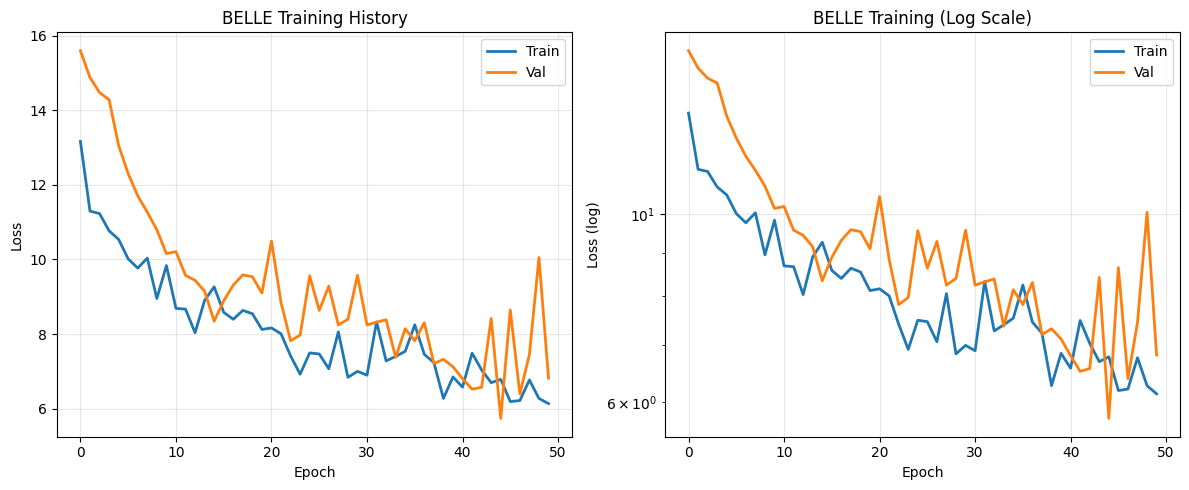


Test Loss: 6.5765


In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train', linewidth=2)
plt.plot(history['val_loss'], label='Val', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BELLE Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train', linewidth=2)
plt.plot(history['val_loss'], label='Val', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.title('BELLE Training (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('belle_training.png', dpi=150)
plt.show()

checkpoint = torch.load('belle_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
test_loss = validate_epoch(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}")

## 10. BELLE Predictions

Demo showing hierarchical sampling

In [20]:
model.eval()

with torch.no_grad():
    for i in range(3):
        x, y1_true, y2_true = test_dataset[i]
        x_tensor = torch.from_numpy(x).float().to(device)
        
        # Get NIG parameters and samples
        gamma1, nu1, alpha1, beta1, y1_sample = model(x_tensor, sample=True)
        gamma2, nu2, alpha2, beta2, y2_sample = model(x_tensor, sample=True)
        
        print(f"\nSample {i+1}:")
        print(f"  Input:  {x.squeeze()}")
        print(f"  Y1 true:   {y1_true.squeeze()}")
        print(f"  Y1 gamma:  {gamma1.cpu().numpy().squeeze()}")
        print(f"  Y1 nu:     {nu1.cpu().numpy().squeeze()}")
        print(f"  Y1 sample: {y1_sample.cpu().numpy().squeeze()}")
        print(f"  Y2 true:   {y2_true.squeeze()}")
        print(f"  Y2 gamma:  {gamma2.cpu().numpy().squeeze()}")
        print(f"  Y2 nu:     {nu2.cpu().numpy().squeeze()}")
        print(f"  Y2 sample: {y2_sample.cpu().numpy().squeeze()}")


Sample 1:
  Input:  [ 0.67778176  0.70646447  0.4732287  -0.29620054]
  Y1 true:   [2.0812414  0.70212483 0.99650383 0.47116065]
  Y1 gamma:  [ 1.9285340e+00 -1.5110198e-03  9.4728601e-01 -3.5480127e-01]
  Y1 nu:     [0.79440784 0.40316936 2.428504   0.7620591 ]
  Y1 sample: [ 1.650993    0.27675706  0.8810426  -0.26578957]
  Y2 true:   [1.8971027  0.48004785 1.18681    0.80059266]
  Y2 gamma:  [ 1.9285340e+00 -1.5110198e-03  9.4728601e-01 -3.5480127e-01]
  Y2 nu:     [0.79440784 0.40316936 2.428504   0.7620591 ]
  Y2 sample: [ 1.3866085 -0.5745529  1.2518431 -0.8666178]

Sample 2:
  Input:  [ 1.0918841   1.02436     0.38091996 -0.04272965]
  Y1 true:   [ 3.4472578   1.1087608   0.6104549  -0.03973719]
  Y1 gamma:  [ 3.472392    0.02816396  0.8758164  -0.28233153]
  Y1 nu:     [0.96263903 0.38505492 2.470763   0.78459156]
  Y1 sample: [ 3.6193948   0.24662392  1.057955   -0.6194786 ]
  Y2 true:   [ 3.6998723  -0.9221267   0.97472954 -0.66489893]
  Y2 gamma:  [ 3.472392    0.02816396  